author : dhq
Date : 2020/03/12

IP i take from Vitis Vison library

# StereoLBM example

This notebook shows how to implement a stereo depth algorithm generated using Vitis in streaming mode. The IP is tested using Middlebury dataset images. The dimensions are 320x240.

## Import libraries

In [1]:
from PIL import Image
import numpy as np
from IPython.display import display, Markdown
from pynq import Xlnk
from pynq import Overlay

## Download the overlay

In [2]:
overlay = Overlay("stereolbm.bit")

Create a helper function to check DMA status

In [3]:
def print_dma_status(dma, direction):
    # direction 0 = read channel, 1 is write
    if(direction is 0):
        print("Read channel")
        offset = 0
    else:
        print("Write channel")
        offset = 0x30
 
    print("Control: " + hex(dma.read(0x0 + offset)))
    print("Status : " + hex(dma.read(0x4 + offset)))
    print("")

## Check the blocks in the overlay

In [4]:
overlay?

## Instantiate the DMAs, and HLS block

In [5]:
dma_imgright = overlay.axi_dma_1    #also used to read
dma_imgleft = overlay.axi_dma_2
output_dma = overlay.axi_dma_0

bitdepth = overlay.convert_bitdepth_acc_0
stereoip = overlay.stereolbm_accel_0 

## Check status of DMAs. 

Control = 0x10003 is DMA ready (started) )

In [6]:
print_dma_status(dma_imgleft, 0)
print_dma_status(dma_imgright, 0)
print_dma_status(output_dma, 1)

Read channel
Control: 0x10003
Status : 0x0

Read channel
Control: 0x10003
Status : 0x0

Write channel
Control: 0x10003
Status : 0x0



In [7]:
left_image_path = "imLsmall.png"
right_image_path = "imRsmall.png"

left_image = Image.open(left_image_path).convert('L') 
#left_image = Image.open(left_image_path)
left_image.load()

right_image = Image.open(right_image_path).convert('L') 
#right_image = Image.open(right_image_path)
right_image.load()

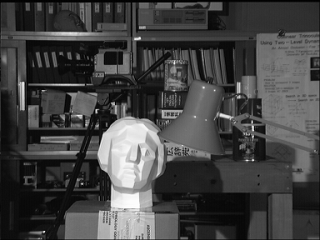

In [8]:
left_img_input_array = np.array(left_image)
left_input_image = Image.fromarray(left_img_input_array)
display(left_image)

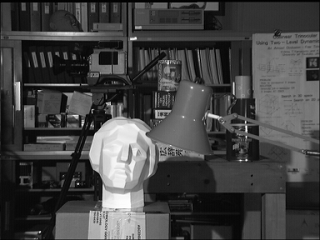

In [9]:
right_img_input_array = np.array(right_image)
right_input_image = Image.fromarray(right_img_input_array)
display(right_image)

In [10]:
def printmd(string):
    display(Markdown('<h1 style="color:DeepPink"> {}</h1>'.format(string)))

In [11]:
left_img_input_array.shape

(240, 320)

In [12]:
right_img_input_array.shape

(240, 320)

## Create input and output buffers

The buffers will be 32 x uint32 numpy types. 

Intitialize the input buffers with a test pattern.

In [13]:
height = 240
width = 320

In [14]:
xlnk = Xlnk()
input_buffer_left = xlnk.cma_array(shape=(height, width), dtype=np.uint8, cacheable=1)
input_buffer_right = xlnk.cma_array(shape=(height, width), dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(height, width), dtype=np.uint8, cacheable=1)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  """Entry point for launching an IPython kernel.


## Display the image in buffer

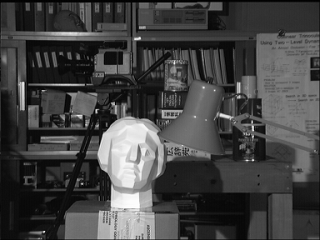

<h1 style="color:DeepPink"> Image size: 320x240 pixels.</h1>

In [16]:
input_buffer_left[:] = left_img_input_array
buf_imageL = Image.fromarray(input_buffer_left)
display(buf_imageL)
printmd("Image size: {}x{} pixels.".format(width, height))


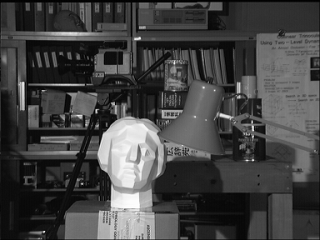

<h1 style="color:DeepPink"> Image size: 320x240 pixels.</h1>

In [17]:
input_buffer_right[:] = left_img_input_array
buf_imageL = Image.fromarray(input_buffer_left)
display(buf_imageL)
printmd("Image size: {}x{} pixels.".format(width, height))

In [47]:
bitdepth.write(0x00,0x81)

In [48]:
bitdepth.write(0x10,0x140)
bitdepth.write(0x18,0xF0)

In [20]:
#------------------------Address Info-------------------
# 0x00 : Control signals
#        bit 0  - ap_start (Read/Write/COH)
#        bit 1  - ap_done (Read/COR)
#        bit 2  - ap_idle (Read)
#        bit 3  - ap_ready (Read)
#        bit 7  - auto_restart (Read/Write)
#        others - reserved
# 0x04 : Global Interrupt Enable Register
#        bit 0  - Global Interrupt Enable (Read/Write)
#        others - reserved
# 0x08 : IP Interrupt Enable Register (Read/Write)
#        bit 0  - Channel 0 (ap_done)
#        bit 1  - Channel 1 (ap_ready)
#        others - reserved
# 0x0c : IP Interrupt Status Register (Read/TOW)
#        bit 0  - Channel 0 (ap_done)
#        bit 1  - Channel 1 (ap_ready)
#        others - reserved
# 0x10 : Data signal of rows
#        bit 31~0 - rows[31:0] (Read/Write)
# 0x14 : reserved
# 0x18 : Data signal of cols
#        bit 31~0 - cols[31:0] (Read/Write)
# 0x1c : reserved
# (SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake)

## SteroLBM Configuration

In this section , the image dimensions are written to the IP core via AXI Lite

In [21]:
stereoip.write(0x10,0x140)
stereoip.write(0x18,0xF0)

In [22]:
print(stereoip.read(0x10))
print(stereoip.read(0x18))

320
240


Start the HLS core by writing 0x1 to the ap_start bit. The status of the HLS core can also be read back from the control register.

HLS block control register: 
*       bit 0  - ap_start (Read/Write/COH)
*        bit 1  - ap_done (Read/COR)
*        bit 2  - ap_idle (Read)
*        bit 3  - ap_ready (Read)
*        bit 7  - auto_restart (Read/Write)

In [22]:
stereoip.write(0x00,0x81)

In [23]:
print(hex(stereoip.read(0x0)))

0x81


Do DMA transfers for inputs A and B and check the DMA statuses 

Status of 0x1002 means the transfer completed successfully

In [ ]:
dma_imgleft.sendchannel.transfer(input_buffer_left)
dma_imgright.sendchannel.transfer(input_buffer_right)
dma_imgleft.sendchannel.wait()
dma_imgright.sendchannel.wait()
stereoip.write(0x00,0x81)
output_dma.recvchannel.wait()
output_dma.recvchannel.transfer(out_buffer)

In [24]:
print_dma_status(dma_imgleft, 0)
print_dma_status(dma_imgright, 0)
print_dma_status(output_dma, 1)

Read channel
Control: 0x10003
Status : 0x0

Read channel
Control: 0x10003
Status : 0x0

Write channel
Control: 0x10003
Status : 0x1002



In [ ]:
result = Image.fromarray(out_buffer)
display(result)

In [27]:
input_buffer_left.close()
input_buffer_right.close()
out_buffer.close()

Free all the memory buffers to avoid memory leaks!

In [28]:
xlnk.xlnk_reset()